In [70]:
from baseline.main_model import *
import pandas as pd
import numpy as np
import os
import copy  
import json
import pickle
from tqdm import tqdm
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import plotly.graph_objects as px

In [71]:
pd.options.display.float_format = '{:.4f}'.format

In [72]:
d = '2021-12-02'

In [73]:
path = '/Users/Mason/Desktop/Volatility/px'
data_paths = [os.path.join(path, f) for f in os.listdir(path)]

In [74]:
file_to_read = open("russell_residual.pkl", "rb")
loaded_dictionary = pickle.load(file_to_read)  #residual from the baseline

In [75]:
file_to_read = open("russell_baseline.pkl", "rb")
loaded_result = pickle.load(file_to_read) #baseline estimation  

In [76]:
file_to_read = open("russell_size.pkl", "rb")
loaded_size = pickle.load(file_to_read) #real size saved easier to transpose 

In [77]:
def prep_data(data, date):
    df = data[data['date'] == str(date)]
    df['TIME_M']  = df['time'].apply(lambda x: '0'+x[:4]+':00' if x[1]==':' else x[:5]+':00')
    df['TIME_M']  = pd.to_timedelta(df['TIME_M'])
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df['datetime'] = df['date'] + df['TIME_M']
    df.set_index('datetime', inplace=True)
    df.drop('sym_suffix', axis=1, inplace=True)
    
    df = df.between_time('9:30:00','16:00:00')
    df['pct_prx'] = df['price'].pct_change().round(decimals = 4) + 1
    df['pr_sd'] = df['pct_prx'].rolling('15T').std()
    df.fillna(pd.Timedelta(seconds=0))
    return df.between_time('9:45:00','15:59:00')

In [78]:
# price_vol = {}
score_dict={}
for i in tqdm(data_paths[:]):
    try:
        date = d
        df = pd.read_csv(i)
        
        df = prep_data(df, date)
        ticker = df['sym_root'].unique()[0]
        if ticker in loaded_dictionary.keys():
            df = df.merge(loaded_dictionary[ticker][['time', 'residual', 'size','est']],
                            how='inner', on = 'time')
            reg = smf.ols(formula = "residual ~ pr_sd",data = df).fit()
            df['vol_est'] = df['est'] + reg.params[1] * df['pr_sd'].values + reg.params[0]
            abs_val = np.abs(df['vol_est'] - df['size'])/ df['size']
            # price_vol[ticker] =  df['vol_est']
            score_dict[ticker] = np.sum(abs_val)/len(abs_val)
    except:
        pass


100%|██████████| 129/129 [00:05<00:00, 25.60it/s]


# Metrics Comparison - PVM vs Baseline

In [79]:
f = open("russell_PVM_metrics.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(score_dict,f)

# close file
f.close()

In [80]:
# read the metrics file for baseline
file_to_read = open("russell_base_metrics.pkl", "rb")
baseline = pickle.load(file_to_read)

In [81]:
final_dict = {key:(score_dict[key], baseline[key]) for key in score_dict}

In [82]:
final = pd.DataFrame.from_dict(final_dict).transpose()
final.reset_index(inplace=True)
final.rename(columns={'index':'stock',0: "pvm", 1: "baseline"}, inplace=True)

In [83]:
len(np.where((final['pvm'] < final['baseline']))[0])

56

In [84]:
final

,stock,pvm,baseline
0,LEN,0.7285,0.7283
1,CARA,43.6307,45.4220
2,SILK,30.6369,34.1545
3,NATH,5.8365,2.0209
4,APPF,33.4401,44.4209
...,...,...,...
101,ENSG,15.6612,14.1253
102,MOV,44.7853,43.7013
103,BLDR,0.6626,0.5329
104,OLN,1.3788,1.3262


In [85]:
final['diff'] = final['baseline']-final['pvm']
final

,stock,pvm,baseline,diff
0,LEN,0.7285,0.7283,-0.0002
1,CARA,43.6307,45.4220,1.7913
2,SILK,30.6369,34.1545,3.5176
3,NATH,5.8365,2.0209,-3.8156
4,APPF,33.4401,44.4209,10.9808
...,...,...,...,...
101,ENSG,15.6612,14.1253,-1.5359
102,MOV,44.7853,43.7013,-1.0840
103,BLDR,0.6626,0.5329,-0.1297
104,OLN,1.3788,1.3262,-0.0526


,stock,pvm,baseline,diff
54,CHRA,59.9825,21.0445,-38.9381
49,TH,93.2412,64.0656,-29.1756
82,PWOD,35.1188,6.8852,-28.2336
94,AMSC,66.1647,40.7781,-25.3866
37,OSW,90.6578,66.4072,-24.2505
...,...,...,...,...
56,VC,17.2114,42.4263,25.2149
83,SFL,59.2127,89.2681,30.0553
61,EZPW,52.4184,82.7504,30.3319
27,VGR,69.9412,101.9786,32.0374


In [87]:
final.sort_values('pvm',inplace=True)
final

,stock,pvm,baseline,diff
46,NFLX,0.4675,0.7122,0.2447
59,MRO,0.5787,0.6080,0.0293
67,PEP,0.5903,0.8139,0.2236
90,MCHP,0.6161,1.1957,0.5796
28,CSX,0.6308,0.8330,0.2022
...,...,...,...,...
27,VGR,69.9412,101.9786,32.0374
99,TTI,77.8456,115.3150,37.4694
37,OSW,90.6578,66.4072,-24.2505
49,TH,93.2412,64.0656,-29.1756


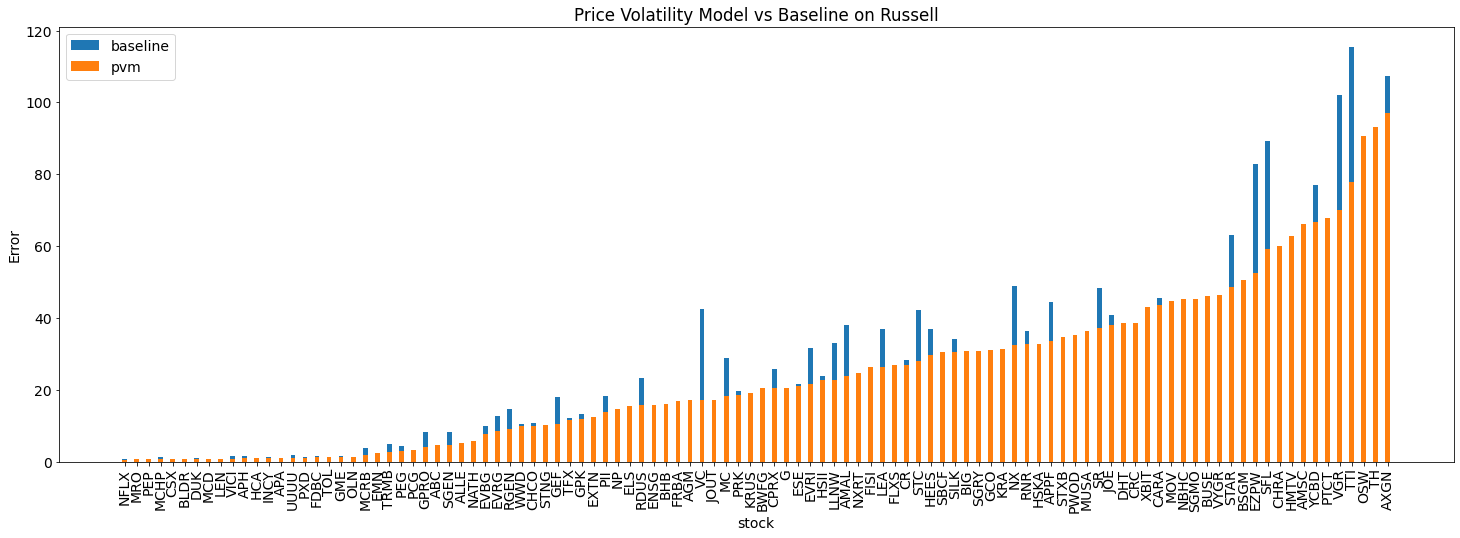

In [88]:
plt.figure(figsize=(25,8))
plt.rcParams['font.size'] = 14
plt.bar(final['stock'],final['baseline'],width=0.4,label = 'baseline')
plt.bar(final['stock'],final['pvm'],width=0.4,label='pvm')
plt.title("Price Volatility Model vs Baseline on Russell")
plt.xlabel("stock")
plt.xticks(rotation = 90)
plt.ylabel("Error")
plt.legend()
plt.show()

In [96]:
final.sort_values('diff',inplace=True)
final

,stock,pvm,baseline,diff
54,CHRA,59.9825,21.0445,-38.9381
49,TH,93.2412,64.0656,-29.1756
82,PWOD,35.1188,6.8852,-28.2336
94,AMSC,66.1647,40.7781,-25.3866
37,OSW,90.6578,66.4072,-24.2505
...,...,...,...,...
56,VC,17.2114,42.4263,25.2149
83,SFL,59.2127,89.2681,30.0553
61,EZPW,52.4184,82.7504,30.3319
27,VGR,69.9412,101.9786,32.0374


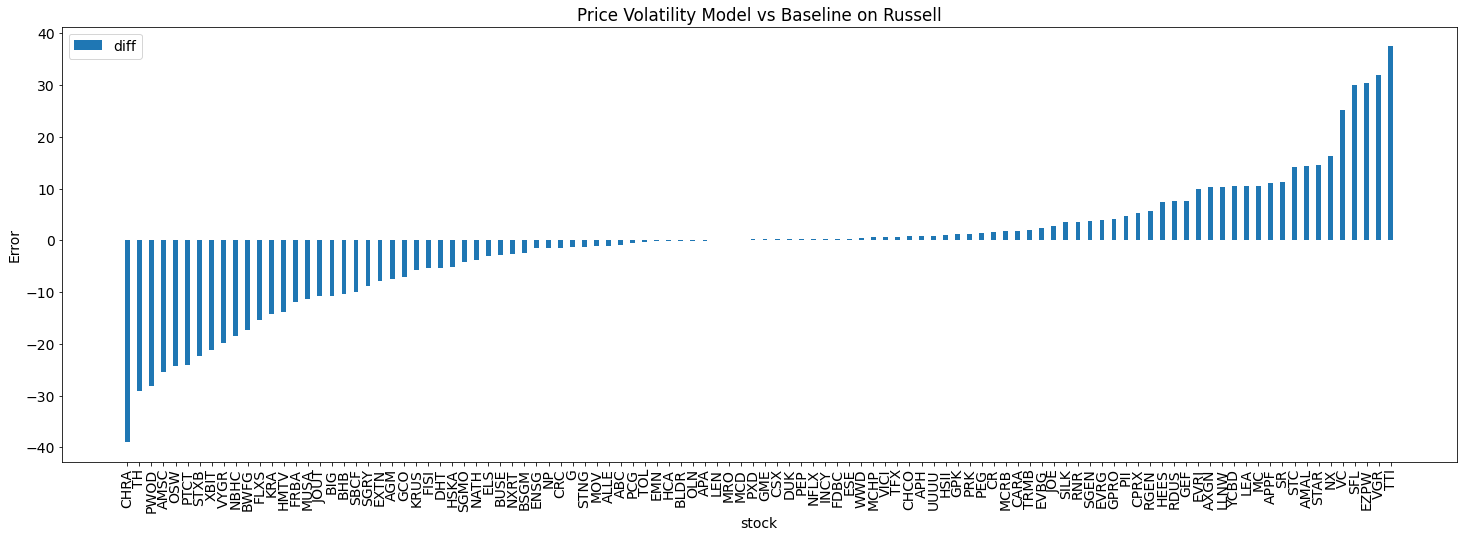

In [97]:
plt.figure(figsize=(25,8))
plt.rcParams['font.size'] = 14
plt.bar(final['stock'],final['diff'],width=0.4,label = 'Diff')
plt.title("Price Volatility Model vs Baseline on Russell")
plt.xlabel("stock")
plt.xticks(rotation = 90)
plt.ylabel("Error")
plt.legend()
plt.show()

In [99]:
liq = pd.read_csv('/Users/Mason/Desktop/Volatility/russell/Russell_1000.txt', header=None)
iliq = pd.read_csv('/Users/Mason/Desktop/Volatility/russell/Russell_2000.txt', header=None)
set1 = set(liq.iloc[:, 0])
set2 = set(iliq.iloc[:, 0])
liq = set1.intersection(final.stock)
iliq = set2.intersection(final.stock)

liq_err = final[final.stock.isin(liq)]
iliq_err = final[final.stock.isin(iliq)]

In [118]:
liq_err.sort_values('baseline')

,stock,pvm,baseline,diff
103,BLDR,0.6626,0.5329,-0.1297
59,MRO,0.5787,0.6080,0.0293
46,NFLX,0.4675,0.7122,0.2447
53,HCA,0.8782,0.7242,-0.1540
0,LEN,0.7285,0.7283,-0.0002
84,MCD,0.6758,0.7361,0.0603
67,PEP,0.5903,0.8139,0.2236
28,CSX,0.6308,0.8330,0.2022
8,TOL,1.2687,0.8458,-0.4229
38,DUK,0.6635,0.8680,0.2045


In [101]:
len(np.where((liq_err['pvm'] < liq_err['baseline']))[0])

23

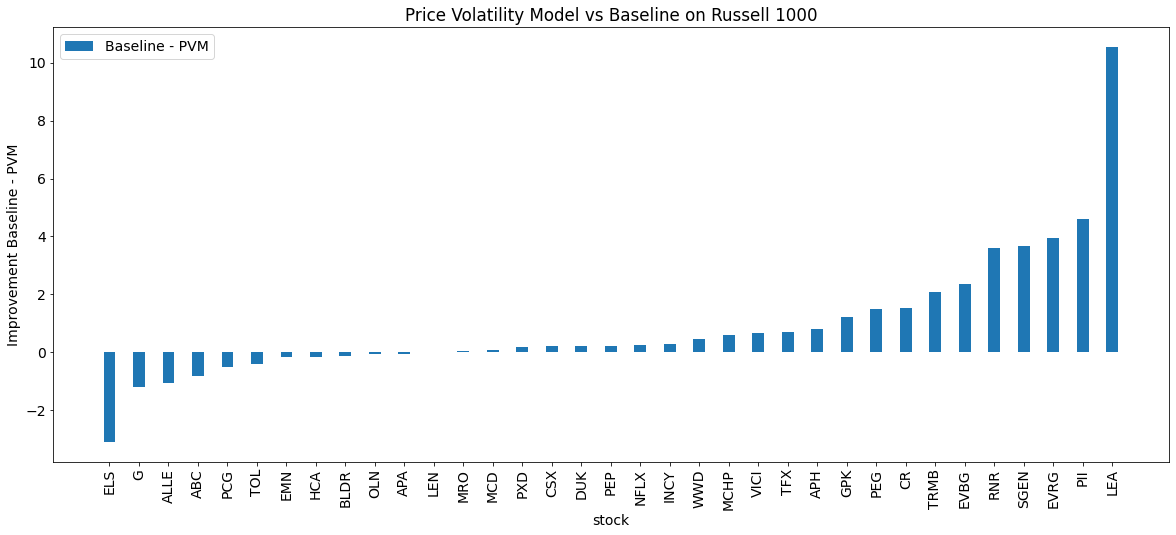

In [112]:
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 14
plt.bar(liq_err['stock'],liq_err['diff'],width=0.4,label = 'Baseline - PVM')
plt.title("Price Volatility Model vs Baseline on Russell 1000")
plt.xlabel("stock")
plt.xticks(rotation = 90)
plt.ylabel("Improvement of PVM")
plt.legend()
plt.show()

In [102]:
len(np.where((iliq_err['pvm'] < iliq_err['baseline']))[0])

33

In [119]:
iliq_err.sort_values('pvm')

,stock,pvm,baseline,diff
98,UUUU,0.9869,1.8822,0.8953
19,FDBC,1.2306,1.5727,0.3421
85,GME,1.2923,1.4733,0.1810
22,MCRB,1.9584,3.7060,1.7476
39,GPRO,4.1372,8.1708,4.0336
...,...,...,...,...
27,VGR,69.9412,101.9786,32.0374
99,TTI,77.8456,115.3150,37.4694
37,OSW,90.6578,66.4072,-24.2505
49,TH,93.2412,64.0656,-29.1756


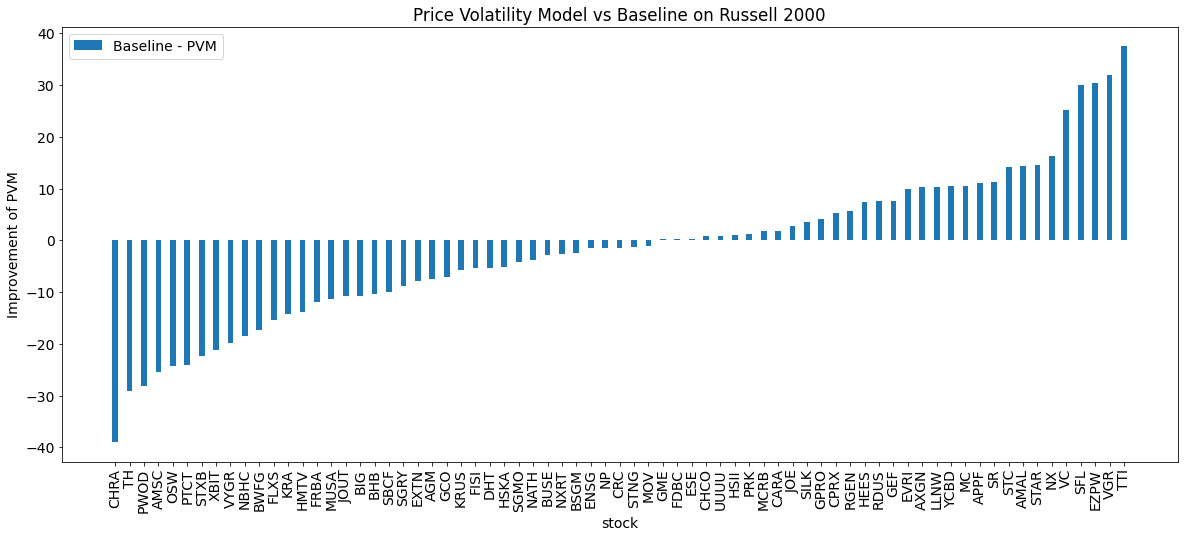

In [113]:
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 14
plt.bar(iliq_err['stock'],iliq_err['diff'],width=0.4,label = 'Baseline - PVM')
plt.title("Price Volatility Model vs Baseline on Russell 2000")
plt.xlabel("stock")
plt.xticks(rotation = 90)
plt.ylabel("Improvement of PVM")

plt.legend()
plt.show()

In [89]:
final.sort_values('pvm')

,stock,pvm,baseline,diff
46,NFLX,0.4675,0.7122,0.2447
59,MRO,0.5787,0.6080,0.0293
67,PEP,0.5903,0.8139,0.2236
90,MCHP,0.6161,1.1957,0.5796
28,CSX,0.6308,0.8330,0.2022
...,...,...,...,...
27,VGR,69.9412,101.9786,32.0374
99,TTI,77.8456,115.3150,37.4694
37,OSW,90.6578,66.4072,-24.2505
49,TH,93.2412,64.0656,-29.1756


In [90]:
sum(final['pvm'])/final.shape[0]

24.395247894508664

In [91]:
sum(final['baseline'])/final.shape[0]

23.628792999015555

In [92]:
import matplotlib.pyplot as plt

In [93]:
data = pd.read_csv('day_mean_pvm.csv')
data

,date,day_mean_pvm
0,['2021-09-01'],20.5133
1,['2021-09-02'],0.0000
2,['2021-09-03'],0.0000
3,['2021-09-06'],0.0000
4,['2021-09-07'],0.0000
...,...,...
85,['2021-12-27'],0.0000
86,['2021-12-28'],0.0000
87,['2021-12-29'],0.0000
88,['2021-12-30'],0.0000


In [94]:
plt.figure(figsize=(16,8))
plt.plot(data['baseline'].values[:44],c = 'r', label = 'Baseline Model')
plt.plot(data['pvm'].values[:44],c = 'b', label = 'Price Volatility Model')
plt.legend()
plt.title("Price Volatility Model vs Baseline on Russell")
plt.xlabel("Date")
plt.ylabel("Total Error")
plt.show()

KeyError: 'baseline'

<Figure size 1152x576 with 0 Axes>